In [1]:
# Import Packages
 
import os
from glob import glob
import matplotlib.pyplot as plt
import requests
import urllib
import pandas as pd
from pandas.io.json import json_normalize
import rasterstats as rs
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.geometry import Point
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import plotting_extent
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep
%run ./data_grabber.ipynb


In [2]:
def polygons_from_raster(tiles):
    '''Takes a list of raster images, 
    ideally tiles from one site, and 
    creates a list of geodataframes
    with raster plot extent as the 
    site geometry.
    ----------
    tiles : list
        List of rasters
    Returns
    -------
    CHM_tile_gdfs : list
        List of geodataframes with raster plot
        extent polygons in gdf format
    '''
    CHM_tile_gdfs=[]
    extents=[]
    for tile in tiles:
        with rio.open(tile) as src:
            extent=plotting_extent(src)
    #raster polygon uses plotting extent for tif (chmCPERextent is plot extent)
        tile_polygon = Polygon([[extent[0], extent[2]],
                                  [extent[0], extent[3]],
                                  [extent[1],extent[3]],
                                  [extent[1],extent[2]]])


    # Making geodataframe from newly made polygon
        CHM_gdf = gpd.GeoDataFrame(crs=src.crs, geometry=[tile_polygon])
        CHM_tile_gdfs.append(CHM_gdf)
        extents.append(extent)
    return CHM_tile_gdfs,extents

In [3]:
# Set working directory
os.chdir(os.path.join(et.io.HOME,'earth-analytics'))

# Get data
CPER_tif_files=open_ecosystem_structure('CPER','2017-05')
CPER_insitu_df=open_woody_veg_structure('CPER','2017-09')
ONAQ_tif_files=open_ecosystem_structure('ONAQ','2017-06')
ONAQ_insitu_df=open_woody_veg_structure('ONAQ','2017-09')

In [4]:
# Create shapefile of buffered insitu sites
# Create paths
CPER_buffered_points_path=os.path.join(
    'data','NEON','CPER','outputs')
ONAQ_buffered_points_path=os.path.join(
    'data','NEON','ONAQ','outputs')

# CPER buffered points
CPER_insitu_gdf=gpd.GeoDataFrame(CPER_insitu_df,geometry=gpd.points_from_xy(
    x=CPER_insitu_df.easting,y=CPER_insitu_df.northing),crs='epsg:32613')
CPER_buffered_points=CPER_insitu_gdf.copy()
CPER_buffered_points['geometry']=CPER_insitu_gdf.geometry.buffer(100)


# CPER_buffered_points.to_file(os.path.join(
#      CPER_buffered_points_path, 'CPER_buffered_points.shp'))

# ONAQ buffered points, extra large buffers for visbility 
# need to be corrected for analyses
ONAQ_insitu_gdf=gpd.GeoDataFrame(ONAQ_insitu_df,geometry=gpd.points_from_xy(
    x=ONAQ_insitu_df.easting,y=ONAQ_insitu_df.northing),crs='epsg:32613')
ONAQ_buffered_points=ONAQ_insitu_gdf.copy()
ONAQ_buffered_points['geometry']=ONAQ_insitu_gdf.geometry.buffer(100)
# ONAQ_buffered_points_path=os.path.join(
#     'data','NEON','ONAQ','outputs')
# ONAQ_buffered_points.to_file(os.path.join(
#      ONAQ_buffered_points_path, 'ONAQ_buffered_points.shp'))


In [5]:
# No longer needed
# CPER_sites=gpd.read_file(os.path.join(
#     CPER_buffered_points_path, 
#     'CPER_buffered_points.shp'))
# ONAQ_sites=gpd.read_file(os.path.join(
#     ONAQ_buffered_points_path,
#     'ONAQ_buffered_points.shp'))

In [6]:
# Create list of tile geometries(extents probably not needed... but just in case)
CPER_tile_geometries, CPER_extents=polygons_from_raster(CPER_tif_files)
ONAQ_tile_geometries,ONAQ_extents=polygons_from_raster(ONAQ_tif_files)

In [7]:
# sanity check cell
# type(CPER_tile_geometries[19])

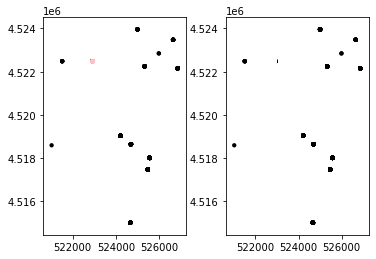

In [8]:
# Test w/ Sarah's code
res_union = gpd.overlay(CPER_tile_geometries[19], CPER_buffered_points, how='intersection')
res_union1 = gpd.overlay(CPER_tile_geometries[0], CPER_buffered_points, how='intersection')
fig, (ax1,ax2) = plt.subplots(1,2)
CPER_buffered_points.plot(ax=ax1,color='black')
res_union.plot(ax=ax1,
              color='pink')
CPER_buffered_points.plot(ax=ax2,color='black')
res_union.plot(ax=ax2,
              color='white')




In [9]:
overlapping_polygons=[]
# Create variable to limit loop iterations
x=0
# loop through selection of tile_geometries
for i in CPER_tile_geometries:
    x+=1
    if x<21:
#check for overlap, only append overlapping sites
        overlap_gdf=gpd.overlay(i,CPER_buffered_points,how='intersection')
        if not len(overlap_gdf) == 0:
#             how can we only append the geometry we need
            overlapping_polygons.append(overlap_gdf)


In [10]:
overlapping_polygons[0]

,plotID,decimalLatitude,decimalLongitude,easting,northing,individualID,height,scientificName,geometry
0,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00139,0.5,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
1,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00190,0.5,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
2,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00185,0.3,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
3,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00185,0.3,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
4,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00185,0.3,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
...,...,...,...,...,...,...,...,...,...
80,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00129,0.5,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
81,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00190,0.5,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
82,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00188,0.7,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."
83,CPER_020,40.785746,-104.707657,524665.95,4515014.39,NEON.PLA.D10.CPER.00188,0.7,Atriplex canescens (Pursh) Nutt.,"POLYGON ((524567.112 4515000.000, 524764.788 4..."


In [11]:
# Old code, CPER_sites can be replaced with CPER_buffered_points
# fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,8))
# CPER_sites.plot(ax=ax1,color='black')
# overlapping_polygons[19].plot(ax=ax1,
#               color='red')
# CPER_sites.plot(ax=ax2,color='black')
# overlapping_polygons[19].plot(ax=ax2,
#               color='white')
# overlapping_polygons[19].plot(ax=ax3)